In [1]:
from pathlib import Path
import os
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import matplotlib.pyplot as plt
from common.helpers import get_roi_from_image
from common.constants import RIGHT_EYE, LEFT_EYE

labels = os.listdir(r"data\train\eyes")
dataset_path = Path(r"data\train\eyes")
model_path_save = os.path.join('models')

In [3]:
from common.constants import ROI_SIZES

img_height = ROI_SIZES[0][0][0] + ROI_SIZES[0][1][0]
img_width = ROI_SIZES[0][0][1] + ROI_SIZES[0][1][1]

In [4]:
img_height, img_width

(60, 60)

In [ ]:

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path=os.path.join('models', 'blaze_face_short_range.tflite'))
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)


def get_eyes_from_images():
    roi_images = []
    categories = ["closed", "open"]
    for index, category in enumerate(categories):
        path_link = os.path.join(dataset_path, category)
        
        for image in os.listdir(path_link):
            image = mp.Image.create_from_file(os.path.join(path_link, image))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_resized = cv2.resize(image_rgb, (img_width, img_height))
            
            # STEP 5: Process the detection result. In this case, visualize it.
            image_copy = np.copy(image_resized.copy())         
            
            roi_images.append([image_copy, index])
    return roi_images

# Prepare training set

In [ ]:
import os
import cv2

# Directory containing the images
input_dir = os.path.join('data', 'train', 'eyes')

# Output directory to save grayscale images

categories = ["closed", "open"]


# Loop through all files in the input directory
for category in categories:
    image_directory = os.path.join(input_dir, category)
    print(image_directory)
    
    output_dir = os.path.join('data', 'processed', category)
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # You can add more extensions if needed
            # Read the image using OpenCV
            image_path = os.path.join(image_directory, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image to the output directory
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, gray_image)

            print(f"Image '{filename}' converted to grayscale and saved successfully.")

print("All images processed and saved.")

In [ ]:
# We don't have to detect eyes from the training images since we already have our eye ROI
# eyes_images, annotated_images = get_eyes_from_images()

# Creating model

In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

batch_size = 32
img_height = 60
img_width = 60

eyes_data_dir = os.path.join('data', 'processed', 'eyes')

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  eyes_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

Found 1234 files belonging to 2 classes.
Using 988 files for training.


In [28]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  eyes_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

Found 1234 files belonging to 2 classes.
Using 246 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['closed', 'open']


In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 60, 60, 1)
(32,)


## Configuring dataset for performance

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarizing the data

In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.002955636 1.0


# Creating keras model

In [33]:
from tensorflow.keras import layers
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 60, 60, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 64)       

In [36]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


31/31 [==============================] - 2s 47ms/step - loss: 0.5294 - accuracy: 0.7652 - val_loss: 0.2532 - val_accuracy: 0.9065
Epoch 2/10
31/31 [==============================] - 1s 38ms/step - loss: 0.2484 - accuracy: 0.9008 - val_loss: 0.1901 - val_accuracy: 0.9309
Epoch 3/10
31/31 [==============================] - 1s 36ms/step - loss: 0.1562 - accuracy: 0.9423 - val_loss: 0.2071 - val_accuracy: 0.9187
Epoch 4/10
31/31 [==============================] - 1s 36ms/step - loss: 0.1281 - accuracy: 0.9484 - val_loss: 0.1039 - val_accuracy: 0.9512
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0815 - accuracy: 0.9666 - val_loss: 0.0584 - val_accuracy: 0.9797
Epoch 6/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0676 - accuracy: 0.9777 - val_loss: 0.0560 - val_accuracy: 0.9837
Epoch 7/10
31/31 [==============================] - 1s 37ms/step - loss: 0.0463 - accuracy: 0.9879 - val_loss: 0.0344 - val_accuracy: 0.9919
Epoch 8/10
31/31 [======

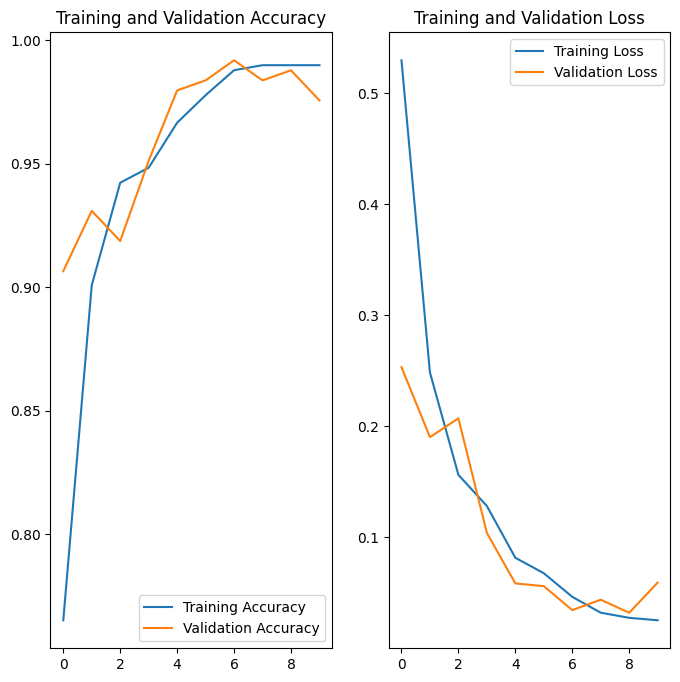

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Getting test data

In [38]:
test_dataset_path = os.path.join('data', 'test', 'eyes')
categories = ["closed", "open"]

eye_images = []
for index, category in enumerate(categories):
    path_link = os.path.join(test_dataset_path, category)
    for image in os.listdir(path_link):
        image = cv2.imread(os.path.join(path_link, image))
        resized_image = cv2.resize(image, (img_height, img_width))
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        
        eye_images.append([gray_image, index])


# Testing the model

In [39]:
accuracy = 0


for img, img_class in eye_images:
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    if (class_names[np.argmax(score)] == 'open' and img_class == 1) or (class_names[np.argmax(score)] == 'closed' and img_class == 0):
        accuracy += 1

    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(class_names[np.argmax(score)], 100 * np.max(score))
    # )

1/1 [==============================] - 0s 19ms/step


# Model accuracy

In [40]:
accuracy/len(eye_images) * 100

97.24770642201835

In [ ]:
eye_model_path = os.path.join(model_path_save, 'eye_classification.keras')
model.save(eye_model_path)